In [1]:
import pandas as pd
import shapely
import geopandas as gpd
import numpy as np
import torch
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings, os
import mysql.connector as mysql
warnings.filterwarnings('ignore')
username = os.environ['MYSQL_user']
password = os.environ['MYSQL_password']
DB = mysql.connect(host = "localhost", user = username, passwd = password, database = "AIRBNB")
cursor = DB.cursor(buffered=True)

## Utils

In [2]:
def read_table_from_db(table_name):
    df = pd.read_sql(f'SELECT * FROM {table_name}', con=DB)
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    df = gpd.GeoDataFrame(df, geometry='geometry')
    return df

In [3]:
def base_information(data):
    df =  pd.DataFrame(data.dtypes, columns=['dtypes'])
    df['Number of missing values'] = data.isna().sum()
    df['Percentage of missing values'] = data.isna().sum()/data.shape[0]
    df['Unique values'] = data.nunique().values
    df['Count'] = data.count().values
    return df.style.background_gradient(cmap='Blues')

In [4]:
def bucket_column(data, column, buckets, labels, nan_label='unknown'):
    data[column] = pd.cut(data[column], bins=buckets, labels=labels, include_lowest=True)
    data[column] = data[column].astype(str)
    data[column] = data[column].replace("nan", pd.NA)
    data[column].fillna(nan_label, inplace=True)
    data[column] = data[column].astype('category')
    return data

In [5]:
class Plots:
    def __init__(self):
        self.quantiles_dict = {"Min": 0, "Q1": 0.25, "Med": 0.5, "Q3": 0.75, "Max": 1}

    def check_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray) and not torch.is_tensor(data):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        data = np.array(data)
        data = data[~np.isnan(data)]
        if(data.ndim == 2):
            data = data.squeeze()
        return data
    
    def histogram_and_box_plot(self, data, name="", annotations=True, bin_size=1):
        data = self.check_data(data=data)
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "histogram"}, {"type": "box"}]])
        fig.add_trace(go.Box(y=data, name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
        fig.add_trace(go.Histogram(x=data, marker=dict(color="rgb(48,70,116)"), showlegend=False, xbins=dict(size=bin_size)), row=1, col=2)
        if type(annotations) == list:
            for x in annotations:
                fig.add_annotation(x=0.4, y=np.quantile(data, self.quantiles_dict[x]), text=x + ": " + str(np.round(np.quantile(data, self.quantiles_dict[x]), 3)), showarrow=False)
        elif type(annotations) == bool:
            if annotations:
                for key, value in self.quantiles_dict.items():
                    fig.add_annotation(x=0.4, y=np.quantile(data, value), text=key + ": " + str(np.round(np.quantile(data, value), 3)), showarrow=False)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{name.title()} distribution<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def barplot_missing_values(self, data, features_names, name=""):
        data = self.check_data(data=data)
        fig = go.Figure()
        fig.add_trace(go.Bar(x=features_names, y=data, marker=dict(color=data, colorscale='rainbow', line=dict(color='black', width=1))))
        fig.update_layout(template="simple_white", width=max(30*len(features_names), 600), height=max(30*len(features_names), 600), title=f"<b>Bar chart {name.title()}<b>", title_x=0.5, yaxis_title="Frequency", xaxis=dict(title="Features", showticklabels=True), font=dict(family="Times New Roman", size=16 ,color="Black"))
        fig.show("png")
    
plots = Plots()

In the notebook: `1. Merge listings.ipynb`, we have already checked for duplicates and removed missing values from `price` (target) variable.

In this notebook I will clean the dataset further by removing missing values from independent variables and removing some of the columns that are not useful for the analysis.

# Load dataset

In [6]:
listings = read_table_from_db('listings')
listings.head()

,listing_id,listing_url,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,2595,https://www.airbnb.com/rooms/2595,2024-09-05,2845,2008-09-09,within a day,67%,24%,f,7.0,...,4.80,4.81,4.40,f,3,3,0,0,0.27,POINT (-73.98559 40.75356)
1,5121,https://www.airbnb.com/rooms/5121,2024-04-07,7356,2009-02-03,within a day,100%,0%,f,2.0,...,4.91,4.47,4.52,f,2,0,2,0,0.28,POINT (-73.95512 40.68535)
2,5136,https://www.airbnb.com/rooms/5136,2024-09-04,7378,2009-02-03,within an hour,100%,100%,f,1.0,...,5.00,4.75,4.75,t,1,1,0,0,0.03,POINT (-73.99454 40.66265)
3,6848,https://www.airbnb.com/rooms/6848,2024-09-05,15991,2009-05-06,within an hour,100%,100%,t,1.0,...,4.80,4.69,4.58,f,1,1,0,0,1.04,POINT (-73.95342 40.70935)
4,6872,https://www.airbnb.com/rooms/6872,2024-09-04,16104,2009-05-07,within a day,50%,0%,f,2.0,...,5.00,5.00,5.00,f,2,0,2,0,0.04,POINT (-73.94255 40.80107)


In [59]:
base_information(listings)

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
listing_id,int64,0,0.000000,35578,35578
listing_url,object,0,0.000000,35578,35578
last_scraped,object,0,0.000000,26,35578
host_id,int64,0,0.000000,16149,35578
host_since,object,1,0.000028,4899,35577
host_response_time,object,5232,0.147057,4,30346
host_response_rate,object,5232,0.147057,82,30346
host_acceptance_rate,object,4219,0.118585,99,31359
host_is_superhost,object,476,0.013379,2,35102
host_listings_count,float64,1,0.000028,272,35577


**Notes:**
- There are several columns with missing values. We will handle them in upcoming steps.

# Missing values

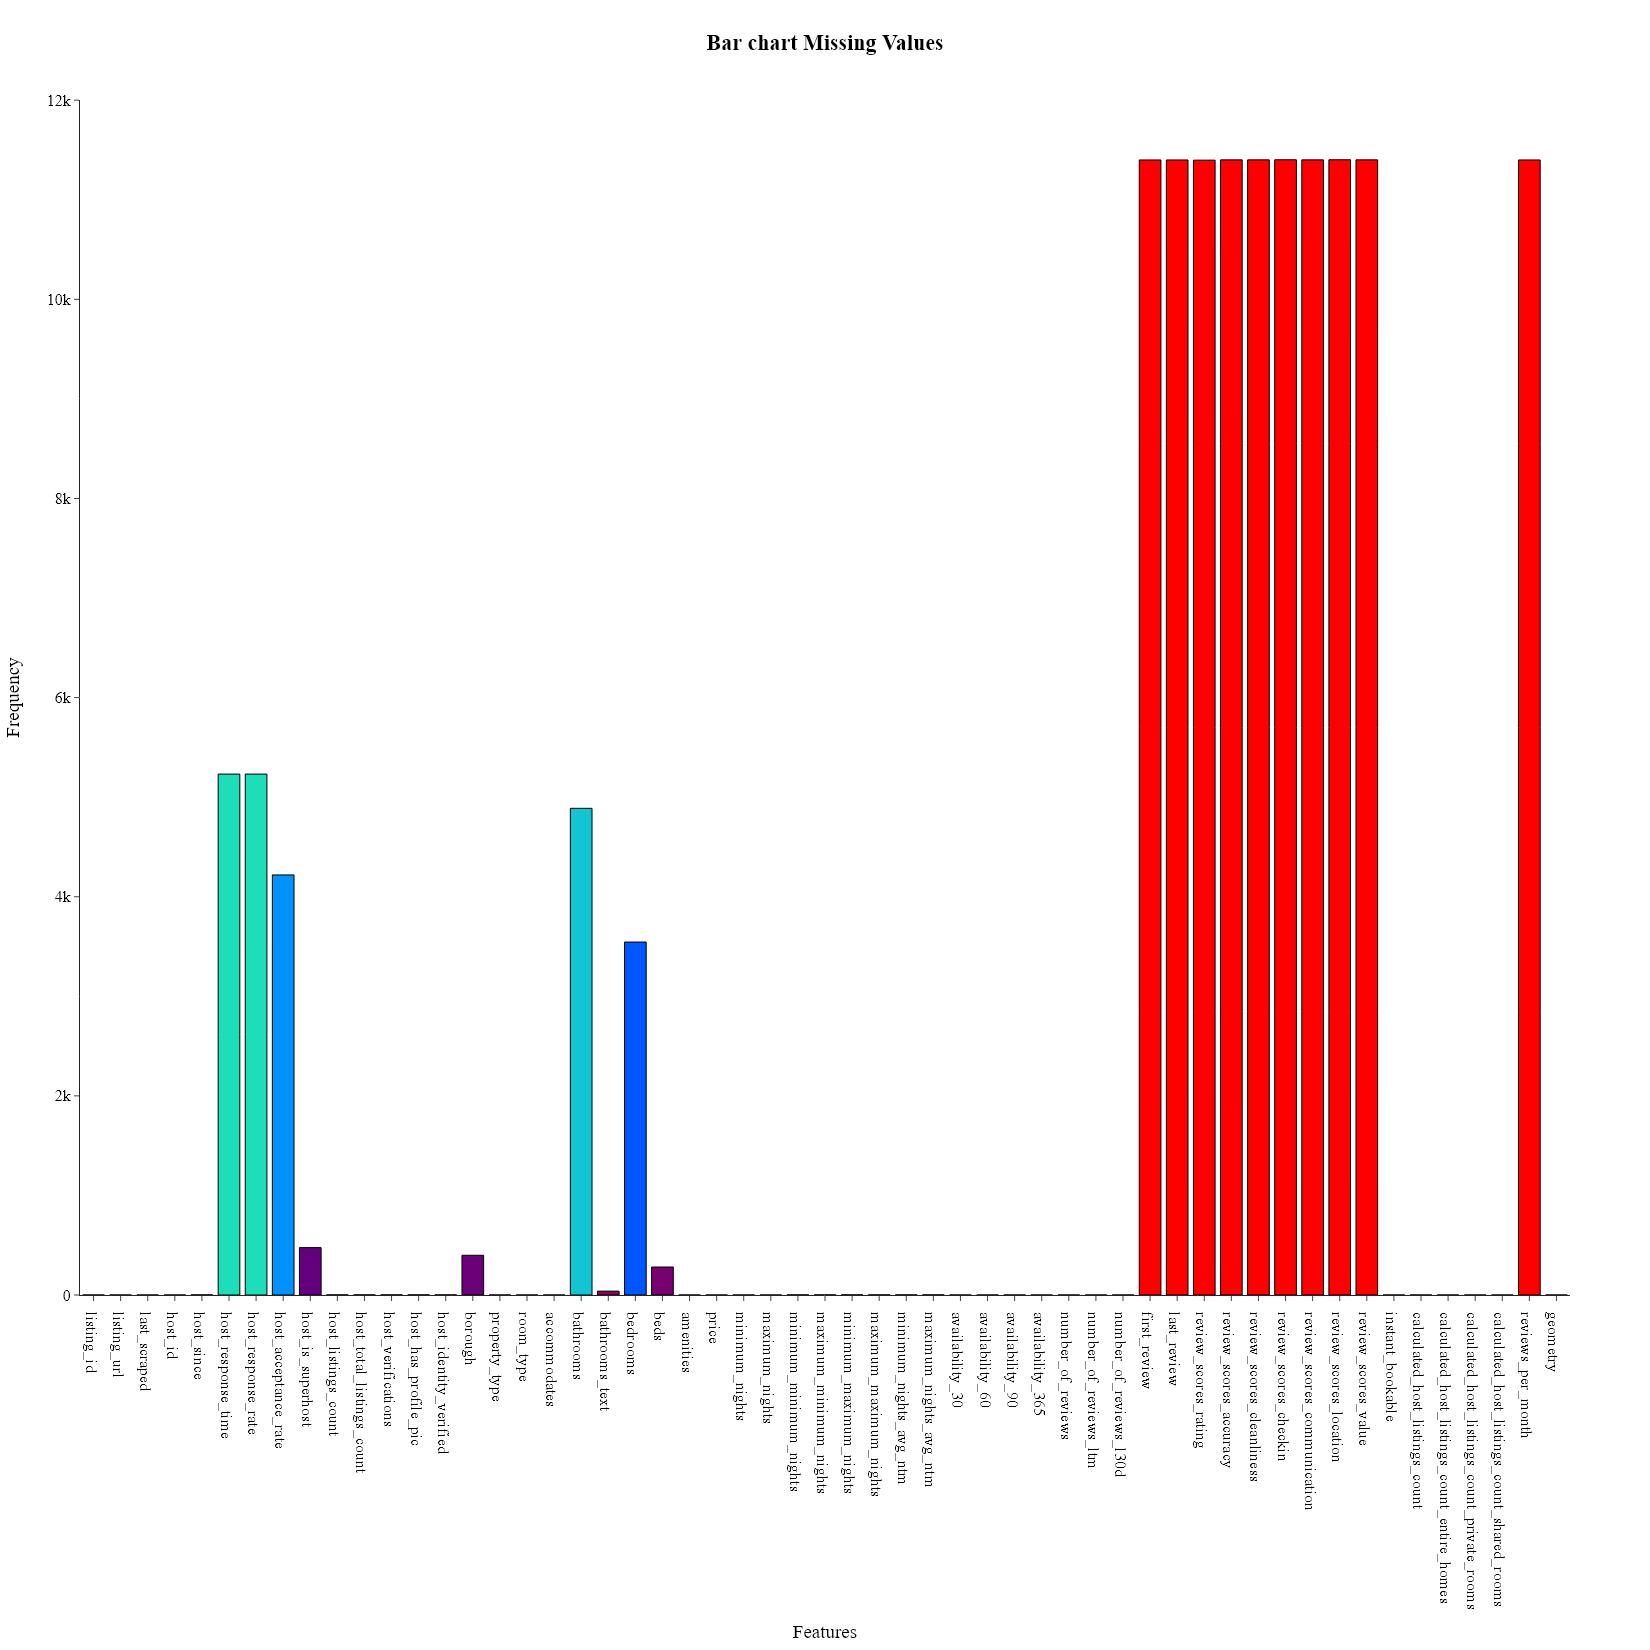

In [60]:
plots.barplot_missing_values(listings.isna().sum(), listings.columns, name="Missing values")

**Notes:**
- There are several columns with missing values. We will handle them in upcoming steps.

## `borough`

`borough` (object) - The borough in which the property is located.

After investigating the missing values in `borough` column, I found that the missing values are actually outside of New York City. I will remove these rows.

In [61]:
listings.dropna(subset=["borough"], inplace=True)

## Host related columns

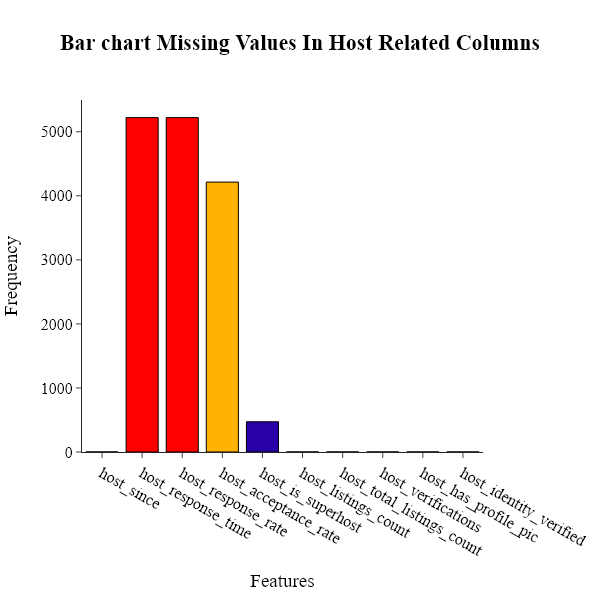

In [62]:
host_related_columns = ['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified']
plots.barplot_missing_values(listings[host_related_columns].isna().sum(), host_related_columns, name="Missing values in host related columns")

There are plenty of columns related to the host (and most of them have missing values).

After some investigation, I have noticed that some of missing values may be imputed based on `host_id` column, below I will show an example.

For `host_id` = 10000, there are two listings in the dataset:
1. `listing_id` = 100 and `host_response_rate` = 100,
2. `listing_id `= 1000 and missing `host_response_rate`.

This suggests that `host_response_rate` may be imputed as 100 for `host_id` = 1000.

The same logic can be applied to other columns and missing values.

In [63]:
def fill_host_missing_values(data, column):
    missing_host_ids = data.loc[data[column].isnull(), 'host_id']
    host_column_map = data.dropna(subset=[column])[['host_id', column, 'last_scraped']]
    # Keep the latest listing data for each host
    host_column_map.sort_values(by='last_scraped', ascending=False, inplace=True)
    host_column_map.drop(columns='last_scraped', inplace=True)
    host_column_map.drop_duplicates(subset='host_id', keep='first', inplace=True)
    host_column_map.set_index('host_id', inplace=True)
    for host_id in missing_host_ids:
        if host_id in host_column_map.index:
            data.loc[data['host_id'] == host_id, column] = host_column_map.loc[host_id, column]
    return data

for column in host_related_columns:
    listings = fill_host_missing_values(data=listings, column=column)

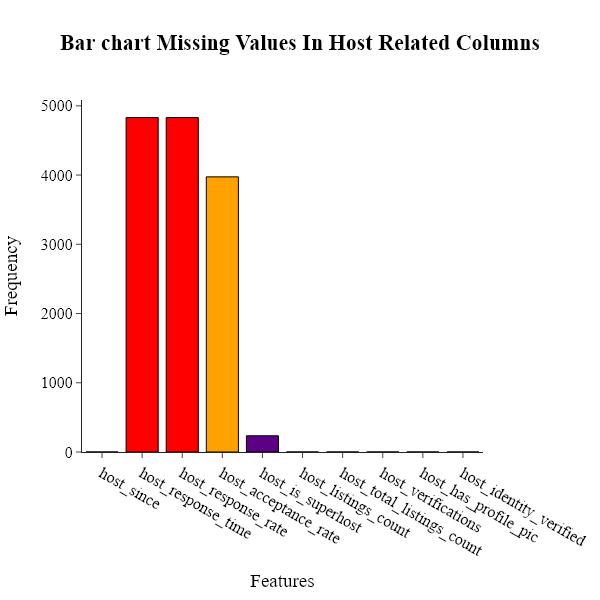

In [64]:
plots.barplot_missing_values(listings[host_related_columns].isna().sum(), host_related_columns, name="Missing values in host related columns")

In [65]:
base_information(listings[host_related_columns])

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
host_since,object,0,0.000000,4891,35179
host_response_time,object,4830,0.137298,4,30349
host_response_rate,object,4830,0.137298,82,30349
host_acceptance_rate,object,3974,0.112965,99,31205
host_is_superhost,object,234,0.006652,2,34945
host_listings_count,float64,0,0.000000,271,35179
host_total_listings_count,float64,0,0.000000,319,35179
host_verifications,object,0,0.000000,6,35179
host_has_profile_pic,object,0,0.000000,2,35179
host_identity_verified,object,0,0.000000,2,35179


**Notes:**
- After imputing missing values for host related columns based on `host_id`, we were able to remove missing values for 6 out of 10 columns.
- However, there are still 4 columns with missing values.

**Conclusions:**
- We can drop `host_id` column as it is not useful for the further analysis.
- We will replace missing values for host related columns based on their unique values.

In [66]:
listings.drop("host_id", axis=1, inplace=True)

## `host_response_time`

`host_response_time` (object) - time it takes for a host to respond to a message.

In [67]:
listings["host_response_time"].value_counts(dropna=False, normalize=True)

host_response_time
within an hour        0.539526
within a few hours    0.177322
None                  0.137298
within a day          0.097814
a few days or more    0.048040
Name: proportion, dtype: float64

Missing values will be imputed with `unknown` category.

In [68]:
listings["host_response_time"].fillna("unknown", inplace=True)

## `host_response_rate`

`host_response_rate` (object) - ratio of messages that host responds to.

In [69]:
listings["host_response_rate"].value_counts(dropna=False, normalize=True)

host_response_rate
100%    0.561585
None    0.137298
99%     0.044885
0%      0.029421
90%     0.023935
          ...   
16%     0.000028
66%     0.000028
53%     0.000028
12%     0.000028
59%     0.000028
Name: proportion, Length: 83, dtype: float64

**Notes:**
- `host_response_rate` is a string column with % sign, we will remove it and convert to float.

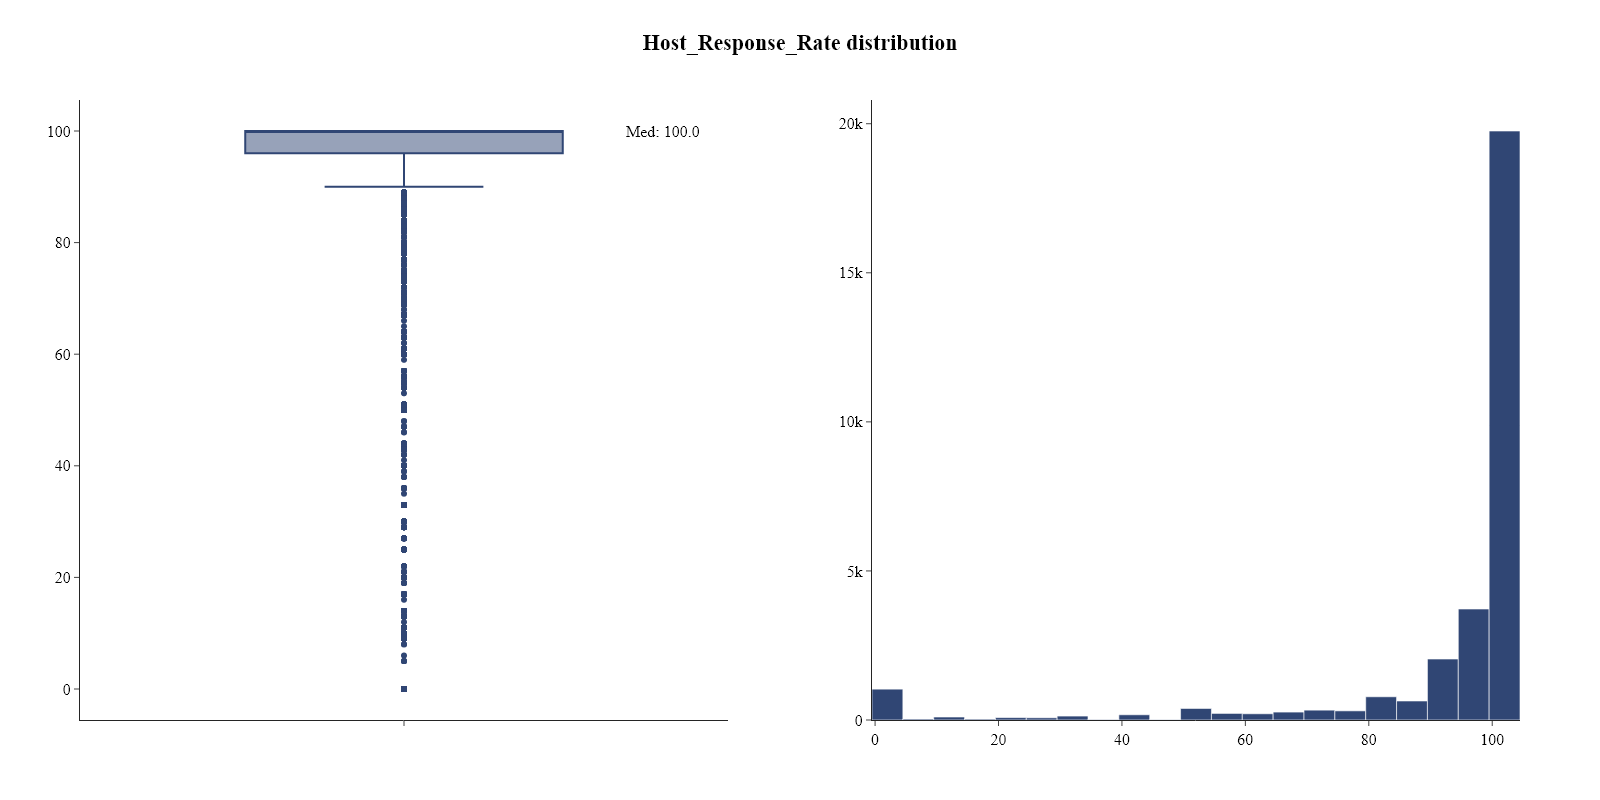

In [70]:
listings["host_response_rate"] = listings["host_response_rate"].str.replace("%", "").astype(float)
plots.histogram_and_box_plot(listings["host_response_rate"], name="host_response_rate", annotations=["Med"], bin_size=5)

**Notes:**
- Most of the values for `host_response_rate` are 100%.

**Conclusions:**
- We will divide it into buckets according to the following division:
    - 0-50%,
    - 51-90%,
    - 91-99%,
    - 100%,
    - unknown.

In [71]:
def bucket_column(data, column, buckets, labels, nan_label='unknown'):
    data[column] = pd.cut(data[column], bins=buckets, labels=labels, include_lowest=True)
    data[column] = data[column].astype(str)
    data[column] = data[column].replace("nan", pd.NA)
    data[column].fillna(nan_label, inplace=True)
    data[column] = data[column].astype('category')
    return data

buckets = [0, 50, 90, 99, 100]
labels = ['0-50%', '51-90%', '91-99%', '100%']
nan_label = 'unknown'
listings = bucket_column(listings, 'host_response_rate', buckets, labels, nan_label)

## `host_acceptance_rate`

`host_acceptance_rate` (object) - ratio of booking requests accepted by the host.

In [72]:
listings["host_acceptance_rate"].value_counts(dropna=False, normalize=True)

host_acceptance_rate
100%    0.258364
None    0.112965
96%     0.046334
99%     0.044060
0%      0.041729
          ...   
6%      0.000142
16%     0.000142
26%     0.000114
3%      0.000114
34%     0.000028
Name: proportion, Length: 100, dtype: float64

**Notes:**
- `host_acceptance_rate` is a string column with % sign, we will remove it and convert to float.

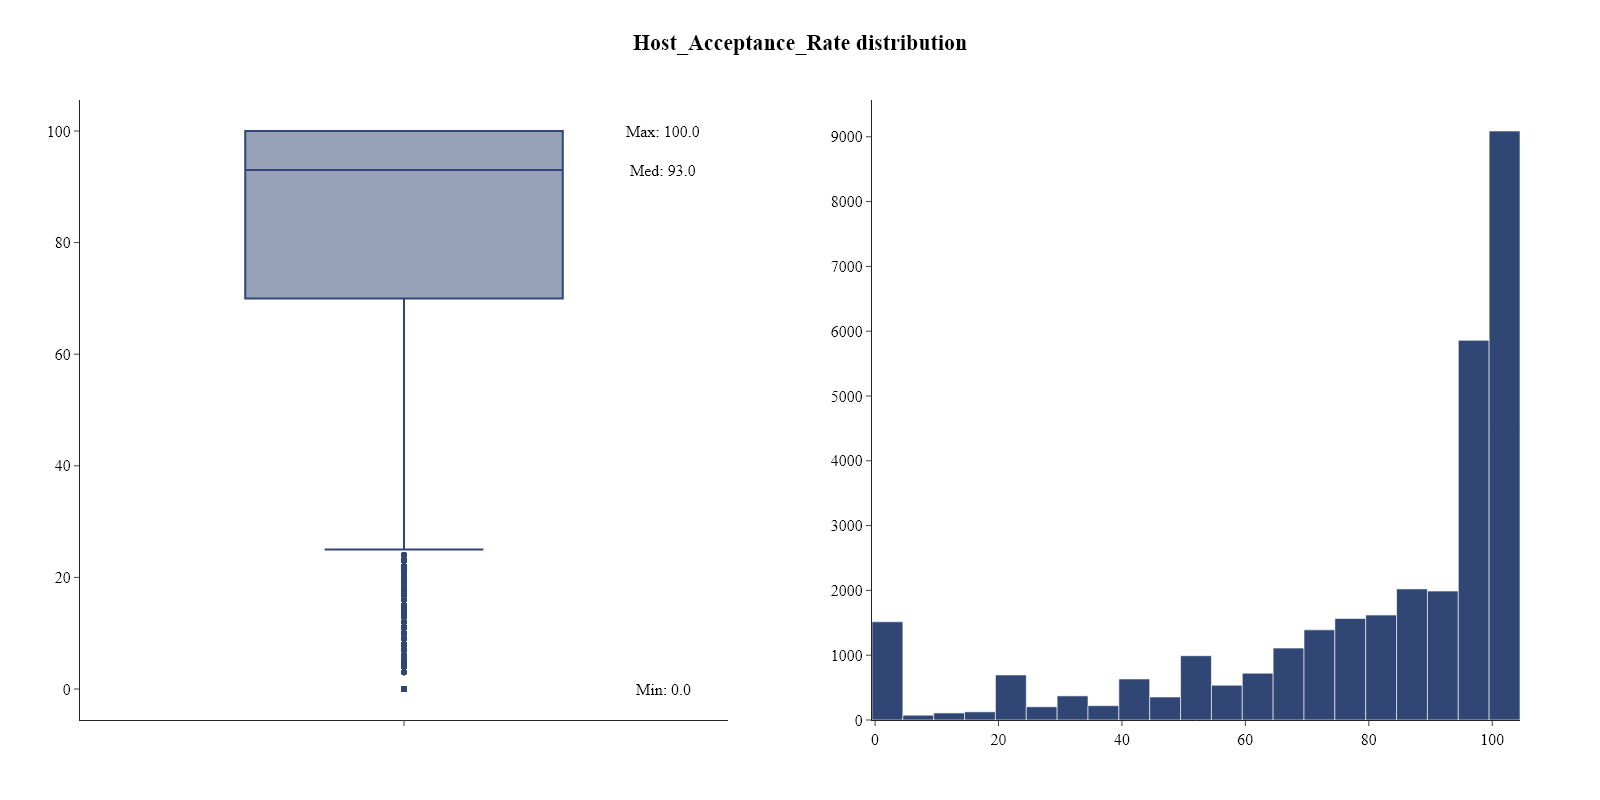

In [73]:
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].str.replace("%", "").astype(float)
plots.histogram_and_box_plot(listings["host_acceptance_rate"], name="host_acceptance_rate", annotations=["Min", "Med", "Max"], bin_size=5)

**Notes:**
- Most of the values for `host_acceptance_rate` are 100%.

**Conclusions:**
- We will divide it into buckets according to the following division:
    - 0-50%,
    - 51-90%,
    - 91-99%,
    - 100%,
    - unknown.

In [74]:
buckets = [0, 50, 90, 99, 100]
labels = ['0-50%', '51-90%', '91-99%', '100%']
nan_label = 'unknown'
listings = bucket_column(listings, 'host_acceptance_rate', buckets, labels, nan_label)

## `host_is_superhost`

`host_is_superhost` (object) - whether the host is a superhost.

In [75]:
listings['host_is_superhost'].value_counts(dropna=False, normalize=True)

host_is_superhost
f       0.729526
t       0.263822
None    0.006652
Name: proportion, dtype: float64

**Notes:**
- Most of the values for `host_is_superhost` are f.
- There is a small percentage of missing values.

**Conclusions:**
- We will replace missing values with f.

In [76]:
listings['host_is_superhost'].fillna('f', inplace=True)

## Property related columns

## `bathrooms`

`bathrooms` (float) - number of bathrooms in the property.

In [77]:
listings['bathrooms'].value_counts(dropna=False, normalize=True)

bathrooms
1.0     0.667302
NaN     0.138947
2.0     0.105915
1.5     0.037494
0.0     0.017567
3.0     0.011484
2.5     0.010006
4.0     0.004463
3.5     0.002530
0.5     0.001961
4.5     0.000796
5.0     0.000739
6.0     0.000199
5.5     0.000142
7.0     0.000142
6.5     0.000085
7.5     0.000085
8.0     0.000057
15.5    0.000028
10.5    0.000028
11.5    0.000028
Name: proportion, dtype: float64

**Notes:**
- There are more than 10% of missing values for `bathrooms` variable.

**Conclusions:**
- We will investigate the relationship between `bathrooms` and `bathrooms_text` variables, because `bathrooms_text` may contain information about the number of bathrooms (and has only ~0.1% of missing values).

In [78]:
listings["bathrooms_text"].value_counts(normalize=True, dropna=False)

bathrooms_text
1 bath               0.516217
1 shared bath        0.175701
2 baths              0.094119
1 private bath       0.078143
2 shared baths       0.031695
1.5 baths            0.028852
1.5 shared baths     0.014725
0 shared baths       0.014014
3 baths              0.011996
2.5 baths            0.010347
0 baths              0.005344
4 baths              0.004605
3 shared baths       0.002956
3.5 baths            0.002700
2.5 shared baths     0.001478
Half-bath            0.001251
4.5 baths            0.001137
None                 0.001109
4 shared baths       0.001023
5 baths              0.000682
Private half-bath    0.000512
Shared half-bath     0.000313
6 baths              0.000199
5.5 baths            0.000199
7 baths              0.000142
3.5 shared baths     0.000085
7.5 baths            0.000085
5 shared baths       0.000085
6.5 baths            0.000057
6 shared baths       0.000057
8 baths              0.000057
15.5 baths           0.000028
10.5 baths           0.00

After analyzing unique values from this column, we will create columns:
- `bathrooms_number` (float) - number of bathrooms in the property,
- `is_bathroom_shared` (bool) - whether the bathroom is shared.

In [79]:
bathrooms_number_mapping = {f'{i} baths': i for i in range(0, 100)}
bathrooms_number_mapping.update({f'{i} shared baths': i for i in range(0, 100)})
bathrooms_number_mapping.update({f'{i}.5 baths': i+0.5 for i in range(0, 100)})
bathrooms_number_mapping.update({f'{i}.5 shared baths': i+0.5 for i in range(0, 100)})
bathrooms_number_mapping.update({f'{i} shared half baths': i/2 for i in range(0, 100)})
bathrooms_number_mapping.update({'1 bath': 1.0, "1 shared bath": 1.0, "1 private bath": 1.0, 'Shared half-bath': 0.5, 'Half-bath': 0.5, 'Private half-bath': 0.5})
listings["bathrooms_number"] = listings["bathrooms_text"].map(bathrooms_number_mapping)
listings["is_bathroom_shared"] = listings["bathrooms_text"].str.contains("shared").astype(bool)

We can now drop `bathrooms` and `bathrooms_text` columns.

In [80]:
listings.drop(["bathrooms", "bathrooms_text"], axis=1, inplace=True)

In [81]:
base_information(listings[["bathrooms_number", "is_bathroom_shared"]])

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
bathrooms_number,float64,39,0.001109,20,35140
is_bathroom_shared,bool,0,0.000000,2,35179


**Notes:**
- We are left with only ~0.1% observations with missing values for `bathrooms_number` after imputing them based on `bathrooms_text` column.

**Conclusions:**
- We will impute missing values for `bathrooms_number` with median (PYTANIE: może lepiej je usunąć?).

In [82]:
listings["bathrooms_number"].fillna(listings["bathrooms_number"].median(), inplace=True)

## `bedrooms`, `beds`

`bedrooms` (float) - number of bedrooms in the property.

`beds` (float) - number of beds in the property.

In [83]:
listings["bedrooms"].value_counts(dropna=False, normalize=True)

bedrooms
1.0     0.566361
2.0     0.156457
NaN     0.100770
0.0     0.073140
3.0     0.064698
4.0     0.026237
5.0     0.009068
6.0     0.002217
7.0     0.000398
8.0     0.000284
9.0     0.000227
16.0    0.000057
14.0    0.000028
15.0    0.000028
11.0    0.000028
Name: proportion, dtype: float64

In [84]:
listings["beds"].value_counts(dropna=False, normalize=True)

beds
1.0     0.573041
2.0     0.218539
3.0     0.088462
4.0     0.042668
0.0     0.035390
5.0     0.015435
6.0     0.010233
NaN     0.007959
8.0     0.003127
7.0     0.002956
9.0     0.000853
10.0    0.000426
12.0    0.000313
11.0    0.000256
13.0    0.000142
19.0    0.000057
22.0    0.000028
42.0    0.000028
16.0    0.000028
21.0    0.000028
14.0    0.000028
Name: proportion, dtype: float64

**Notes:**
- There are less missing values for `beds` than for `bedrooms`.

**Conclusions:**
- We will impute missing values for `bedrooms` based on `beds` column.

Firstly let's check how many rows there are with missing values for `bedrooms` and `beds` columns.

In [85]:
missing_values = listings[listings["bedrooms"].isna() & listings["beds"].isna()]
print(f"Number of rows with missing values for both bedrooms and beds: {missing_values.shape[0]}")

Number of rows with missing values for both bedrooms and beds: 95


There are small number of observations with missing values for `bedrooms` and `beds` columns.

We will drop these observations from the dataset.

In [86]:
listings.drop(missing_values.index, inplace=True)

Next to impute missing values for both columns we will use the following approach:
1. We will extract information about the number of beds in the property from the `beds` column.
2. For the obtained value from the `beds` column, we will check the most frequently occurring value from the bedrooms column for this number of beds (in the entire dataset).
3. The value from the bedrooms column will be replaced by the value from point 2.

In [87]:
beds_most_common_bedrooms_mapping = listings.groupby("beds")["bedrooms"].apply(lambda x: x.mode().max())
listings["bedrooms"] = listings["bedrooms"].fillna(listings["beds"].map(beds_most_common_bedrooms_mapping))

We will do the same for the `beds` column.

In [88]:
bedrooms_most_common_beds_mapping = listings.groupby("bedrooms")["beds"].apply(lambda x: x.mode().max())
listings["beds"] = listings["beds"].fillna(listings["bedrooms"].map(bedrooms_most_common_beds_mapping))

In [89]:
base_information(listings[["bedrooms", "beds"]])

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
bedrooms,float64,0,0.000000,14,35084
beds,float64,0,0.000000,20,35084


**Notes:**
- We have imputed missing values for `bedrooms` and `beds` columns.

## Terms of stay related columns

### `minimum_minimum_nights`, `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights`, `minimum_nights_avg_ntm`, `maximum_nights_avg_ntm`

There is only one observation missing for each of these columns.

We will impute missing values with the corresponding value from the `minimum_nights` and `maximum_nights` columns.

In [90]:
listings["minimum_minimum_nights"].fillna(listings["minimum_nights"], inplace=True)
listings["maximum_minimum_nights"].fillna(listings["minimum_nights"], inplace=True)
listings["minimum_maximum_nights"].fillna(listings["maximum_nights"], inplace=True)
listings["maximum_maximum_nights"].fillna(listings["maximum_nights"], inplace=True)
listings["minimum_nights_avg_ntm"].fillna(listings["minimum_nights"], inplace=True)
listings["maximum_nights_avg_ntm"].fillna(listings["maximum_nights"], inplace=True)

## Customer reviews related columns

## `first_review`, `last_review`

`first_review` (object) - date of the first review.

`last_review` (object) - date of the last review.

First thing that we will do is to convert these columns to datetime format.

In [91]:
listings["first_review"] = pd.to_datetime(listings["first_review"])
listings["last_review"] = pd.to_datetime(listings["last_review"])
listings["last_scraped"] = pd.to_datetime(listings["last_scraped"])

We will create columns:
- `time_since_first_review` (int) - time since the first review in days,
- `time_since_last_review` (int) - time since the last review in days.

In [92]:
listings["time_since_first_review"] = (listings["last_scraped"] - listings["first_review"]).dt.days
listings["time_since_last_review"] = (listings["last_scraped"] - listings["last_review"]).dt.days

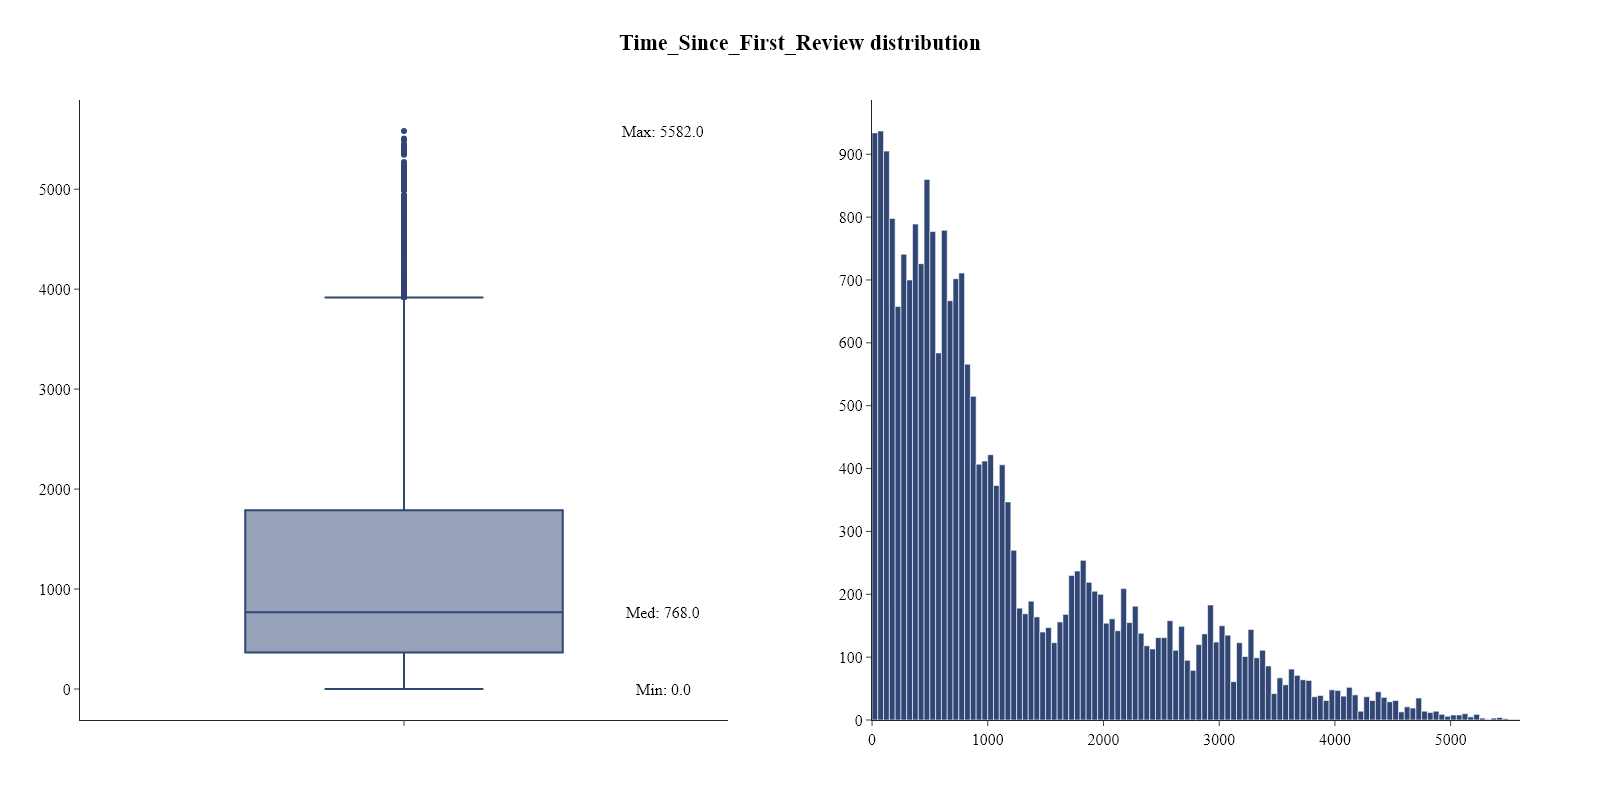

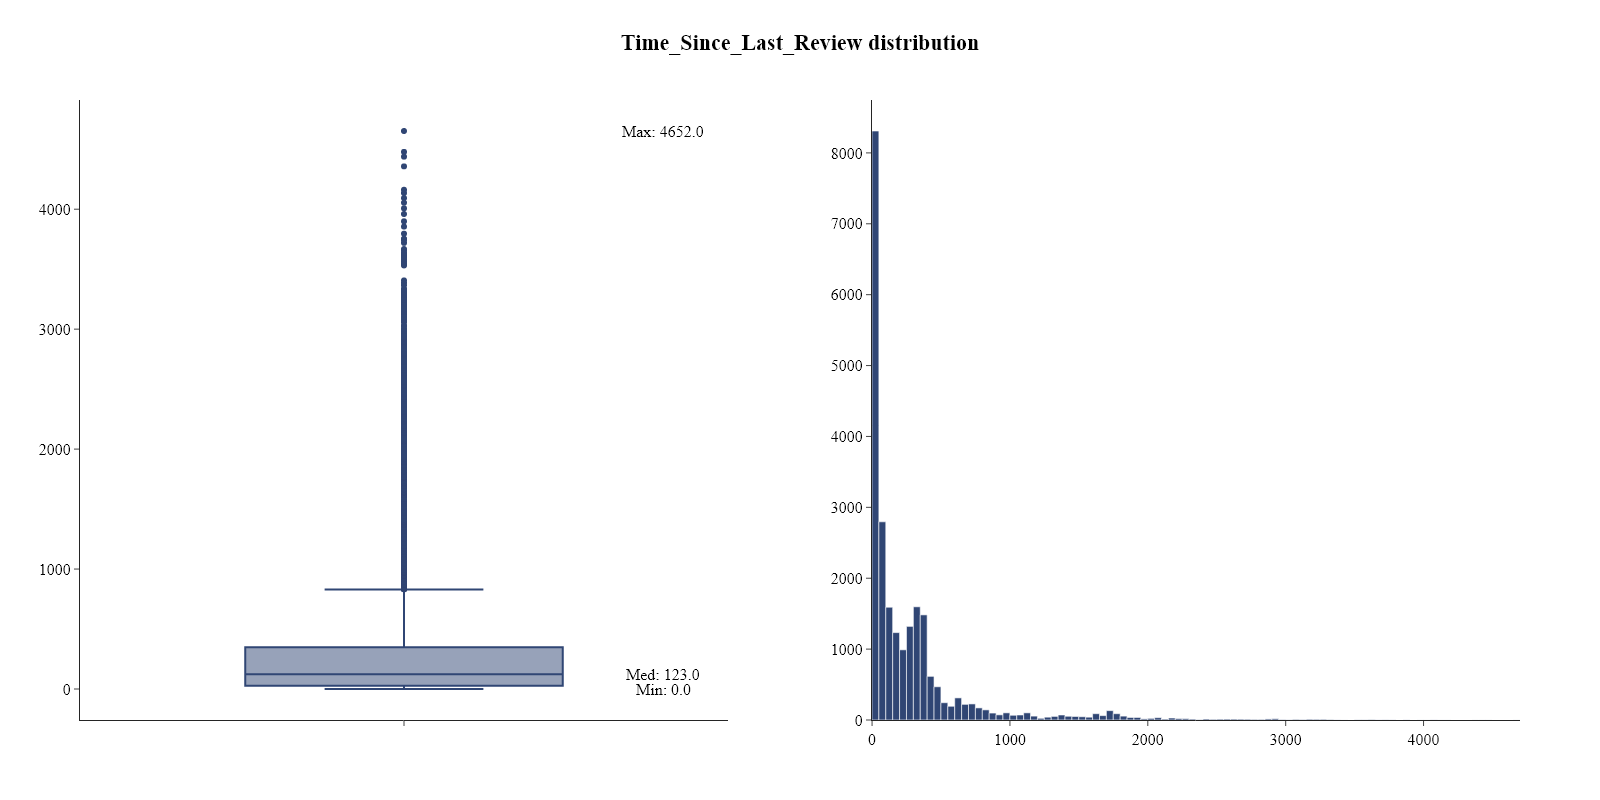

In [93]:
plots.histogram_and_box_plot(listings["time_since_first_review"], name="time_since_first_review", annotations=["Min", "Med", "Max"], bin_size=50)
plots.histogram_and_box_plot(listings["time_since_last_review"], name="time_since_last_review", annotations=["Min", "Med", "Max"], bin_size=50)

**Notes:**
- Both features have left skewed distributions.
- `time_since_first_review` has much higher median value than `time_since_last_review`.

**Conclusions:**
- We will create buckets for both columns, however due to the fact that `time_since_first_review` has on average higher values, we will create different buckets for both columns to avoid imbalanced classes.

In [94]:
buckets = [0, 182, 365, 730, 1095, np.max(listings["time_since_first_review"])+1]
labels = ['0-6 months', '6-12 months', '1-2 years', '2-3 years', '3 years and more']
nan_label = 'unknown'
listings = bucket_column(listings, 'time_since_first_review', buckets, labels, nan_label)

In [95]:
buckets = [0, 14, 30, 60, 182, 365, np.max(listings["time_since_last_review"])+1]
labels = ['0-2 weeks', '2-4 weeks', '1-2 months', '2-6 months', '6-12 months', '1 year and more']
nan_label = 'unknown'
listings = bucket_column(listings, 'time_since_last_review', buckets, labels, nan_label)

We can now drop `first_review` and `last_review` columns.

In [96]:
listings.drop(["first_review", "last_review"], axis=1, inplace=True)

### `review_scores_rating`, `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, `review_scores_value`

`review_scores_rating` (float) - average rating of the property.

`review_scores_accuracy` (float) - accuracy of the property description.

`review_scores_cleanliness` (float) - cleanliness of the property.

`review_scores_checkin` (float) - check-in experience.

`review_scores_communication` (float) - communication with the host.

`review_scores_location` (float) - location of the property.

`review_scores_value` (float) - value for money.

Firstly we will plot the distribution of these columns.

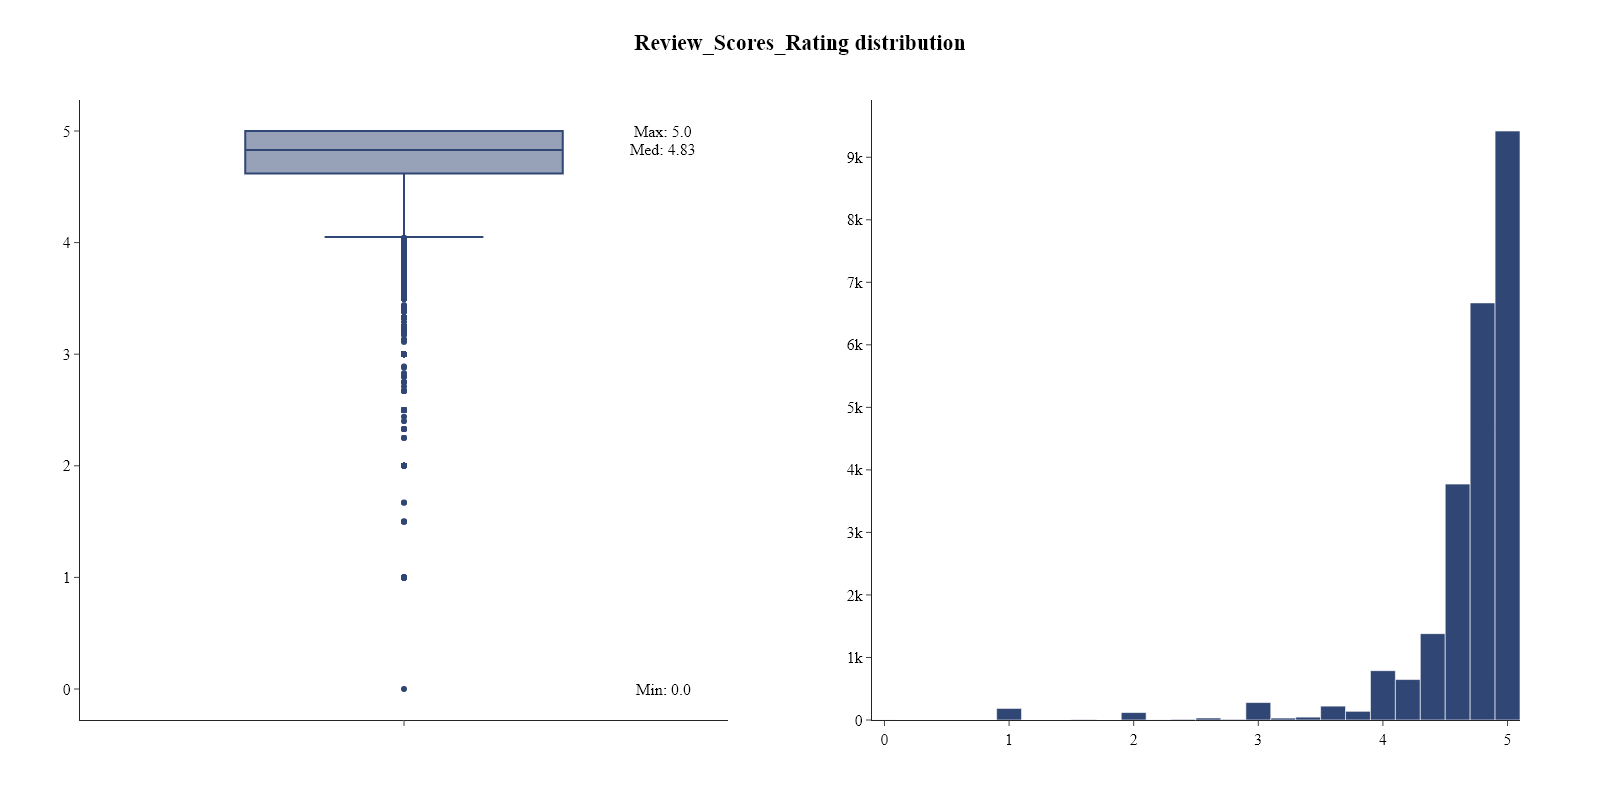

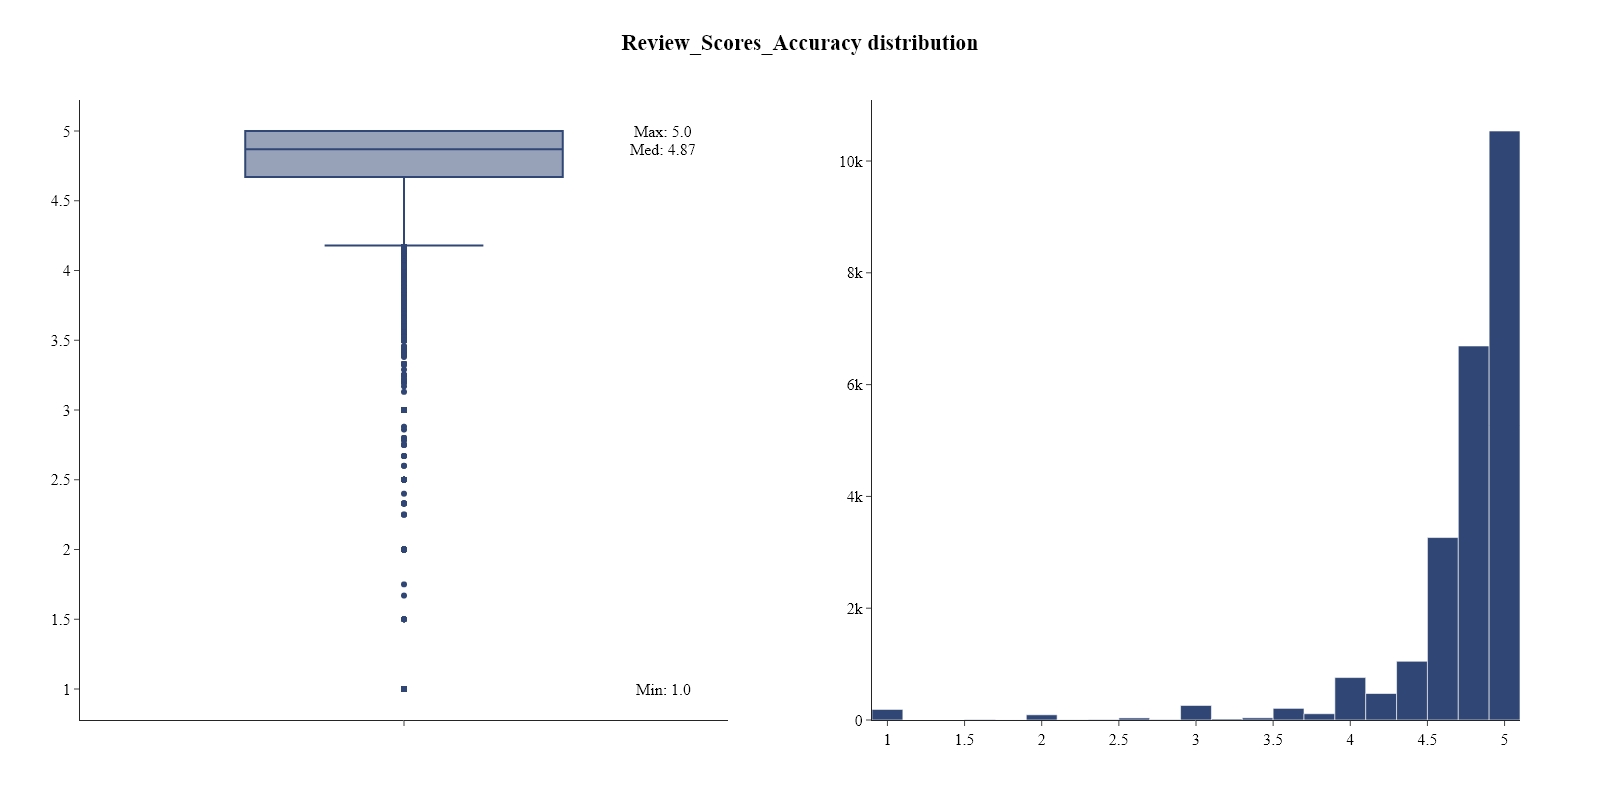

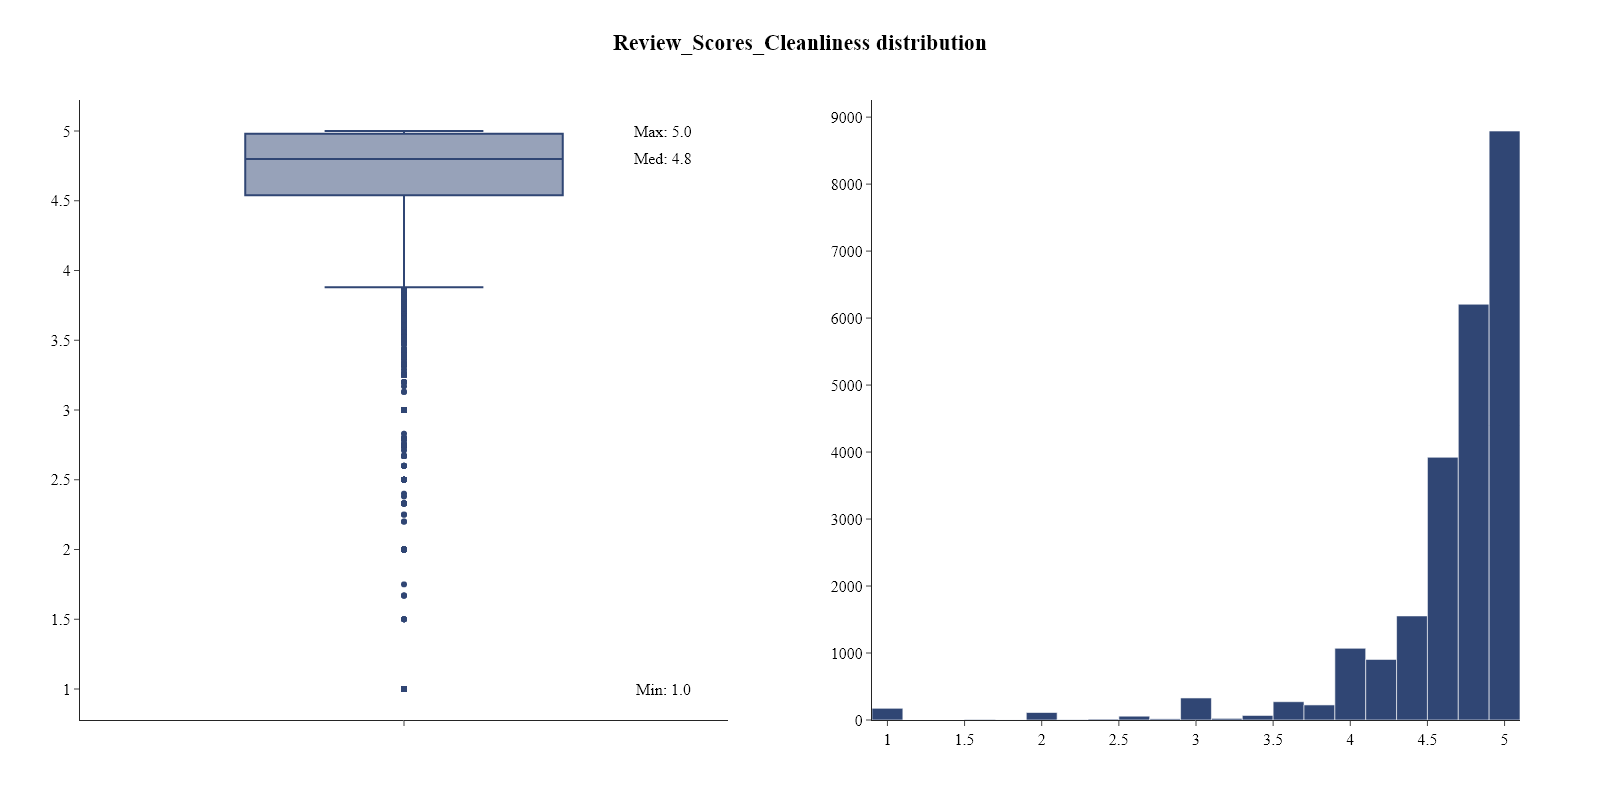

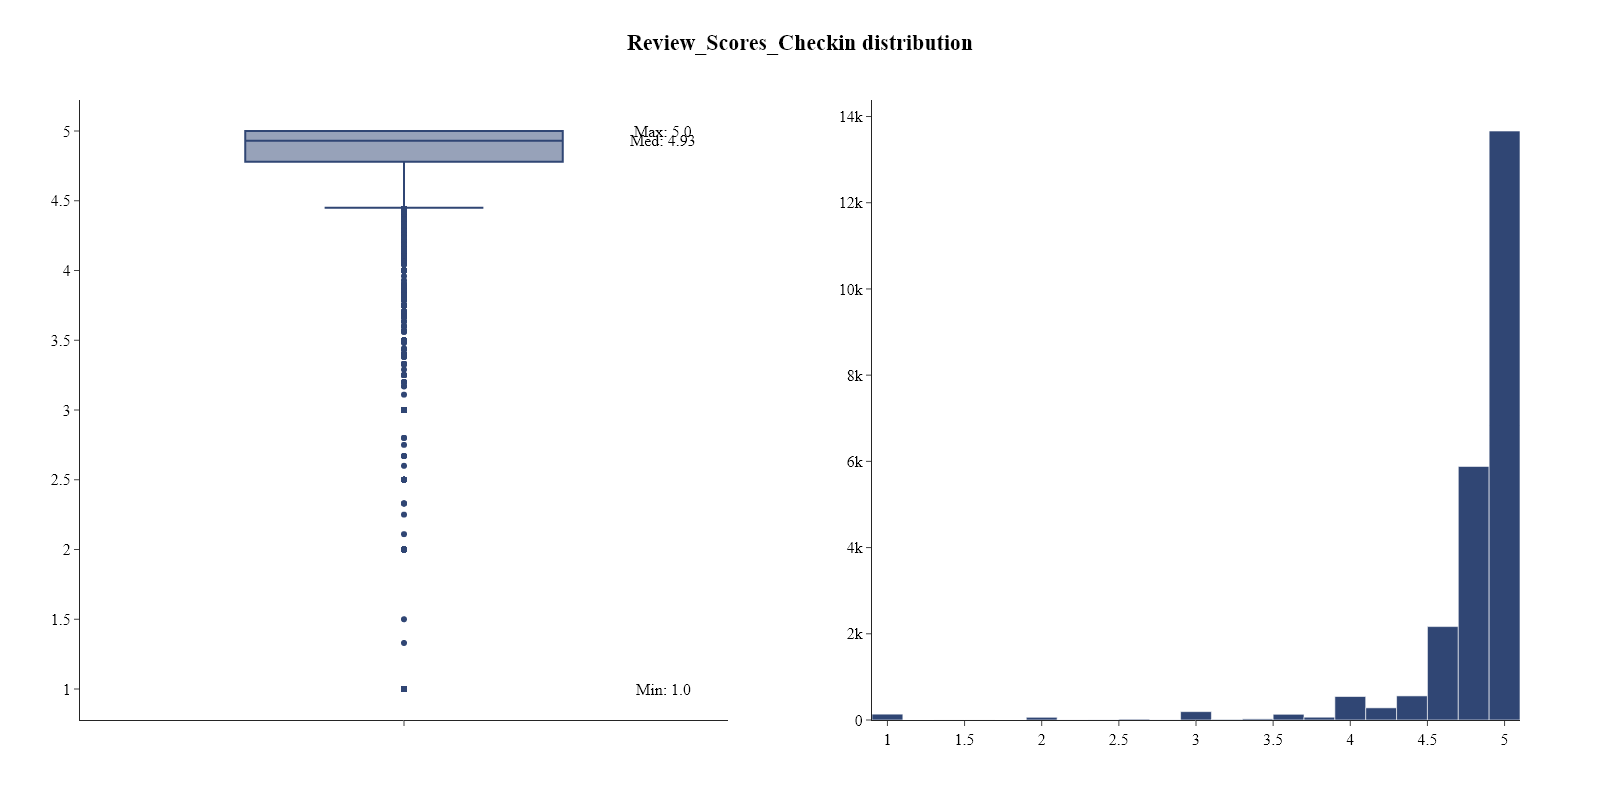

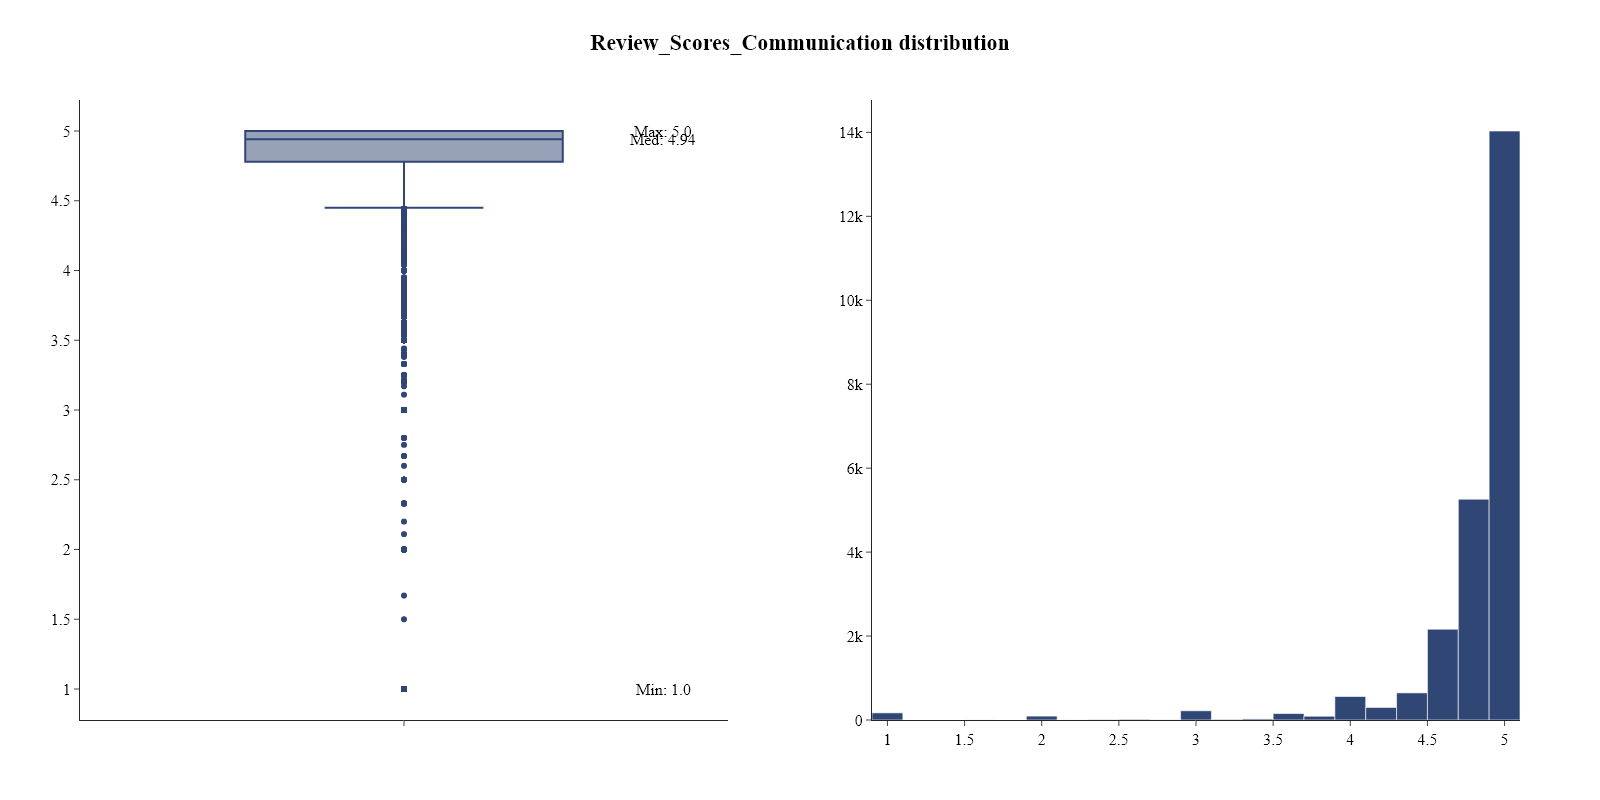

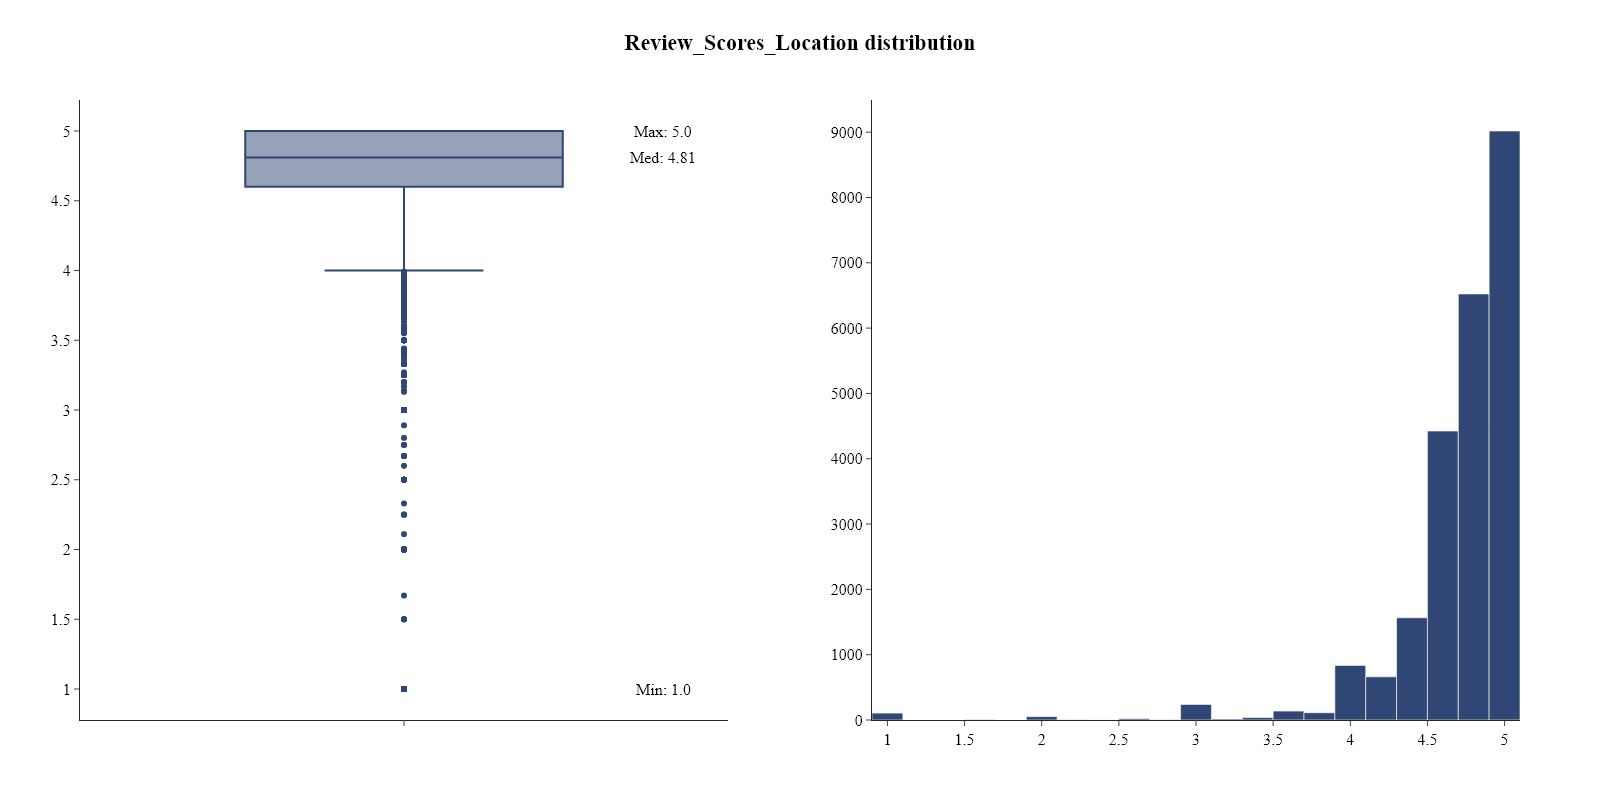

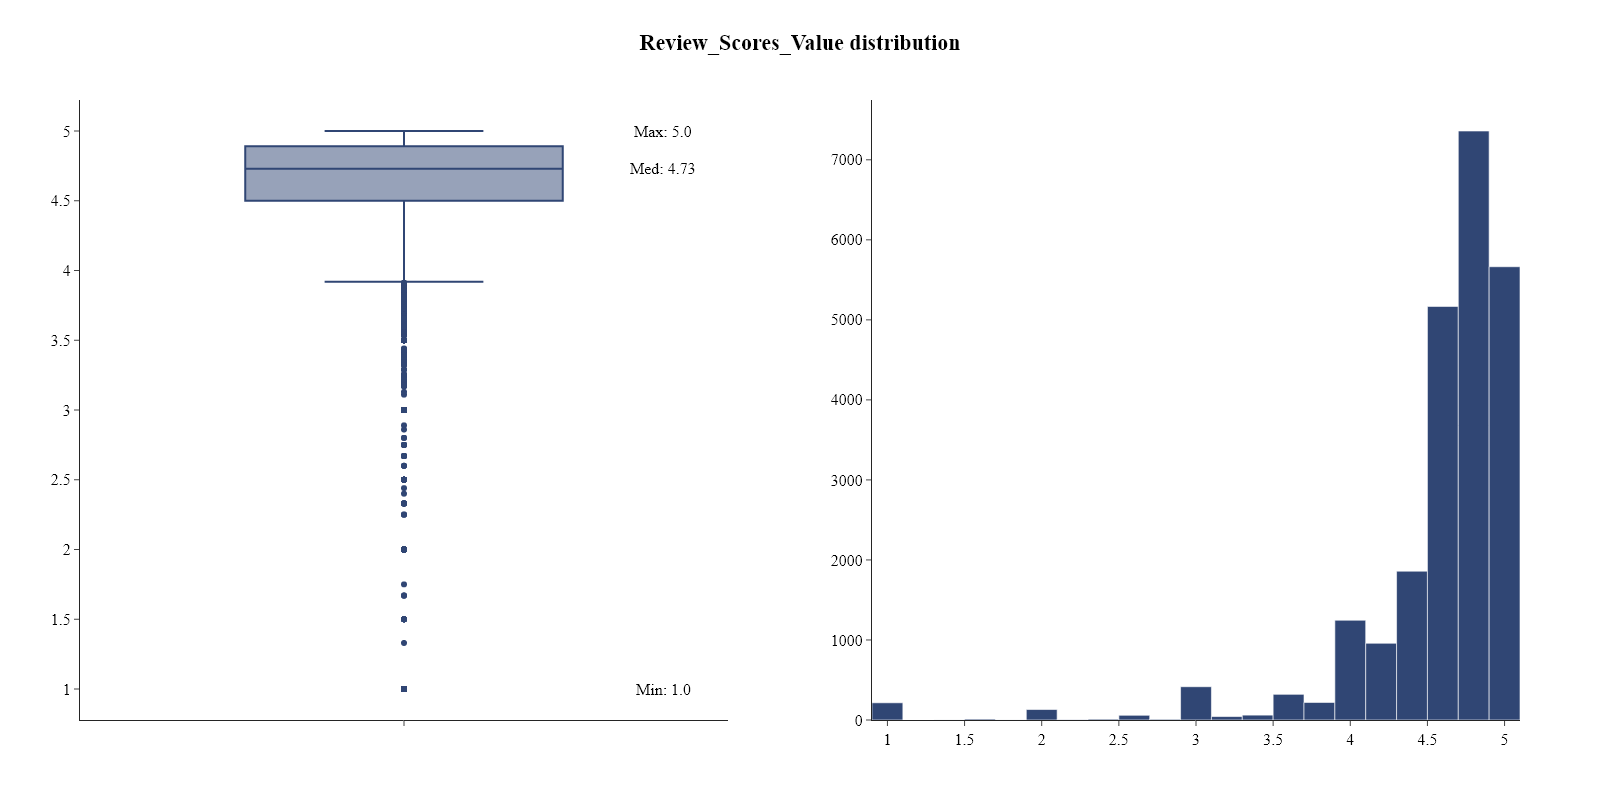

In [97]:
plots.histogram_and_box_plot(listings["review_scores_rating"], name="review_scores_rating", annotations=["Min", "Med", "Max"], bin_size=0.2)
plots.histogram_and_box_plot(listings["review_scores_accuracy"], name="review_scores_accuracy", annotations=["Min", "Med", "Max"], bin_size=0.2)
plots.histogram_and_box_plot(listings["review_scores_cleanliness"], name="review_scores_cleanliness", annotations=["Min", "Med", "Max"], bin_size=0.2)
plots.histogram_and_box_plot(listings["review_scores_checkin"], name="review_scores_checkin", annotations=["Min", "Med", "Max"], bin_size=0.2)
plots.histogram_and_box_plot(listings["review_scores_communication"], name="review_scores_communication", annotations=["Min", "Med", "Max"], bin_size=0.2)
plots.histogram_and_box_plot(listings["review_scores_location"], name="review_scores_location", annotations=["Min", "Med", "Max"], bin_size=0.2)
plots.histogram_and_box_plot(listings["review_scores_value"], name="review_scores_value", annotations=["Min", "Med", "Max"], bin_size=0.2)

**Notes:**
- All of the columns have right skewed distributions.

**Conclusions:**
- We will create buckets for all of the columns:
    - 0-50%,
    - 51-70%,
    - 71-90%,
    - 91-100%,
    - unknown.

In [98]:
buckets = [0, 3, 4, 4.5, 4.8, 5.0]
labels = ['0-50%', '51-80%', '81-90%', '91-95%', '96-100%']
nan_label = 'unknown'
for column in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]:
    listings = bucket_column(listings, column, buckets, labels, nan_label)

## `reviews_per_month`

`reviews_per_month` (float) - number of reviews per month.

We will check correlation between `reviews_per_month` and other review related columns.

In [99]:
listings[["reviews_per_month", "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"]].corr(method='spearman')

,reviews_per_month,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
reviews_per_month,1.000000,0.705551,0.757503,0.500322
number_of_reviews,0.705551,1.000000,0.742793,0.369539
number_of_reviews_ltm,0.757503,0.742793,1.000000,0.563453
number_of_reviews_l30d,0.500322,0.369539,0.563453,1.000000


**Notes:**
- Feature is highly correlated with other review related columns.

**Conclusions:**
- There is no need to keep `reviews_per_month` column in the dataset as it is highly correlated with other review related columns and has many missing values.

In [100]:
listings.drop("reviews_per_month", axis=1, inplace=True)

# Summary

In [101]:
base_information(listings)

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
listing_id,int64,0,0.000000,35084,35084
listing_url,object,0,0.000000,35084,35084
last_scraped,datetime64[ns],0,0.000000,23,35084
host_since,object,0,0.000000,4889,35084
host_response_time,object,0,0.000000,5,35084
host_response_rate,category,0,0.000000,5,35084
host_acceptance_rate,category,0,0.000000,5,35084
host_is_superhost,object,0,0.000000,2,35084
host_listings_count,float64,0,0.000000,271,35084
host_total_listings_count,float64,0,0.000000,319,35084


**Notes:**
- Adter cleaning the dataset we have no missing values left in the dataset.
- We have:
  - transformed some of the columns to more useful format.
  - imputed missing values for some of the columns.
  - created new columns based on the existing ones.
  - removed some of the columns that are not useful for the analysis.



# Save cleaned listings to DB

In [102]:
table_name = "listings_cleaned"
drop_table_script = f"""
DROP TABLE IF EXISTS {table_name};
"""
cursor.execute(drop_table_script)

In [103]:
create_script = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    listing_id BIGINT PRIMARY KEY NOT NULL,
    listing_url VARCHAR(255) NOT NULL,
    last_scraped DATE NOT NULL,
    host_since DATE NOT NULL,
    host_response_time VARCHAR(255) NOT NULL,
    host_response_rate VARCHAR(255) NOT NULL,
    host_acceptance_rate VARCHAR(255) NOT NULL,
    host_is_superhost VARCHAR(255) NOT NULL,
    host_listings_count INT NOT NULL,
    host_total_listings_count INT NOT NULL,
    host_verifications TEXT NOT NULL,
    host_has_profile_pic VARCHAR(255) NOT NULL,
    host_identity_verified VARCHAR(255) NOT NULL,
    borough VARCHAR(255) NOT NULL,
    property_type VARCHAR(255) NOT NULL,
    room_type VARCHAR(255) NOT NULL,
    accommodates INT NOT NULL,
    bedrooms FLOAT NOT NULL,
    beds FLOAT NOT NULL,
    amenities TEXT NOT NULL,
    price VARCHAR(255) NOT NULL,
    minimum_nights INT NOT NULL,
    maximum_nights INT NOT NULL,
    minimum_minimum_nights INT NOT NULL,
    maximum_minimum_nights INT NOT NULL,
    minimum_maximum_nights INT NOT NULL,
    maximum_maximum_nights INT NOT NULL,
    minimum_nights_avg_ntm INT NOT NULL,
    maximum_nights_avg_ntm INT NOT NULL,
    availability_30 INT NOT NULL,
    availability_60 INT NOT NULL,
    availability_90 INT NOT NULL,
    availability_365 INT NOT NULL,
    number_of_reviews INT NOT NULL,
    number_of_reviews_ltm INT NOT NULL,
    number_of_reviews_l30d INT NOT NULL,
    review_scores_rating VARCHAR(255) NOT NULL,
    review_scores_accuracy VARCHAR(255) NOT NULL,
    review_scores_cleanliness VARCHAR(255) NOT NULL,
    review_scores_checkin VARCHAR(255) NOT NULL,
    review_scores_communication VARCHAR(255) NOT NULL,
    review_scores_location VARCHAR(255) NOT NULL,
    review_scores_value VARCHAR(255) NOT NULL,
    instant_bookable VARCHAR(255) NOT NULL,
    calculated_host_listings_count INT NOT NULL,
    calculated_host_listings_count_entire_homes INT NOT NULL,
    calculated_host_listings_count_private_rooms INT NOT NULL,
    calculated_host_listings_count_shared_rooms INT NOT NULL,
    geometry TEXT NOT NULL,
    bathrooms_number FLOAT NOT NULL,
    is_bathroom_shared BOOLEAN NOT NULL,
    time_since_first_review VARCHAR(255) NOT NULL,
    time_since_last_review VARCHAR(255) NOT NULL
);
"""
cursor.execute(create_script)
DB.commit()

In [104]:
# Insert data into the table
column_names = ', '.join([column for column in listings.columns])
values_string = ', '.join(['%s' for _ in range(len(listings.columns))])
insert_script = f"INSERT INTO {table_name} ({column_names}) VALUES ({values_string})"
values = listings.values.tolist()
values = [[None if pd.isnull(value) else value.strftime('%Y-%m-%d') if (isinstance(value, pd.Timestamp)) else int(value) if (isinstance(value, int)) else value.wkt if (isinstance(value, shapely.geometry.point.Point)) else value for value in row] for row in values]
cursor.executemany(insert_script, values)
DB.commit()
cursor.close()

In the next notebook: `2. Metadata_EDA.ipynb`, we will perform exploratory data analysis to better understand the dataset.